The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
# TODO : import the dataset
df = pd.read_csv('AB_Test_Results.csv')

In [65]:
# TODO : take a quick look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [68]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [70]:
# TODO : Look at the distribution of the number of unique groups for each user
df['VARIANT_NAME'].unique()

array(['variant', 'control'], dtype=object)

In [71]:
unique_variants = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
unique_variants.value_counts()

,count
VARIANT_NAME,
1,4783
2,1541


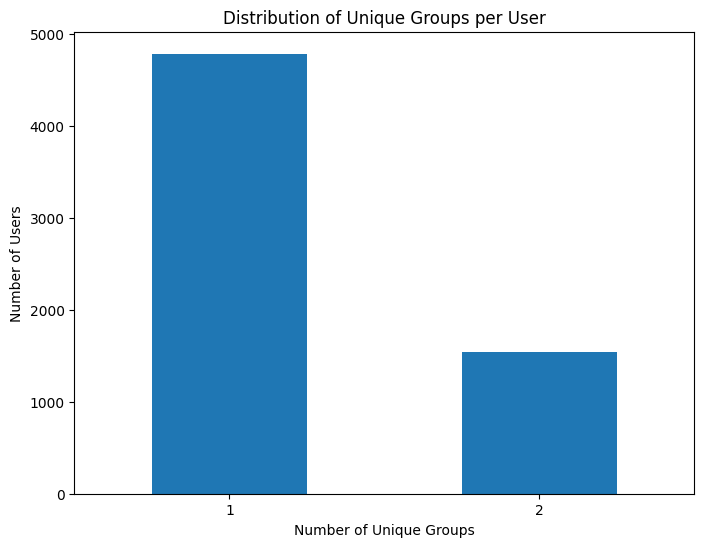

In [72]:
plt.figure(figsize=(8, 6))
unique_variants.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Unique Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

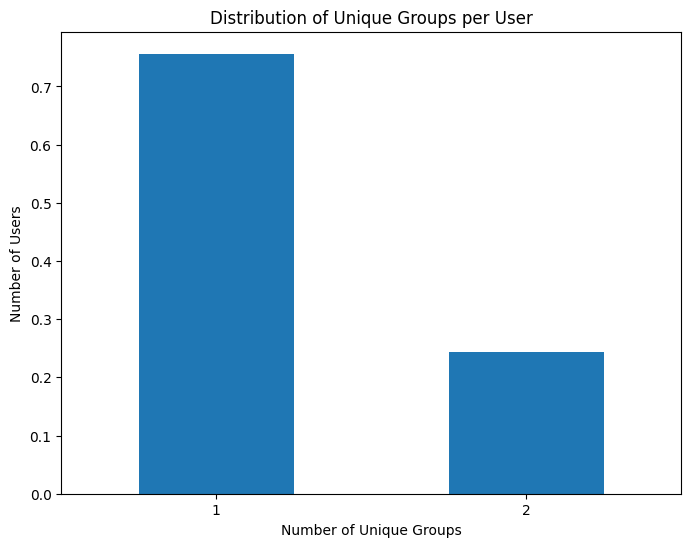

In [73]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
relative = unique_variants.value_counts(normalize=True)
plt.figure(figsize=(8, 6))
relative.sort_index().plot(kind='bar')
plt.title('Distribution of Unique Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

What can you observe ? Should we exclude these users ? Why ?

In [74]:
# TODO : users have 1 A/B test group ?
unique_variants = unique_variants[unique_variants == 1]
print(f'{len(unique_variants)} users have 1 A/B test group')
# TODO : Take only these users
new_df = df[df['USER_ID'].isin(unique_variants.index)]

4783 users have 1 A/B test group


In [76]:
# TODO : Leave only records with users with the 1st ab test group
test_group = new_df.groupby('USER_ID').first().reset_index()
# TODO : Check that the number of users matches what it was before the exception
test_count = test_group['USER_ID'].nunique()
print(f'{test_count} users have the 1st ab test group')

4783 users have the 1st ab test group


Let's see how the data is distributed

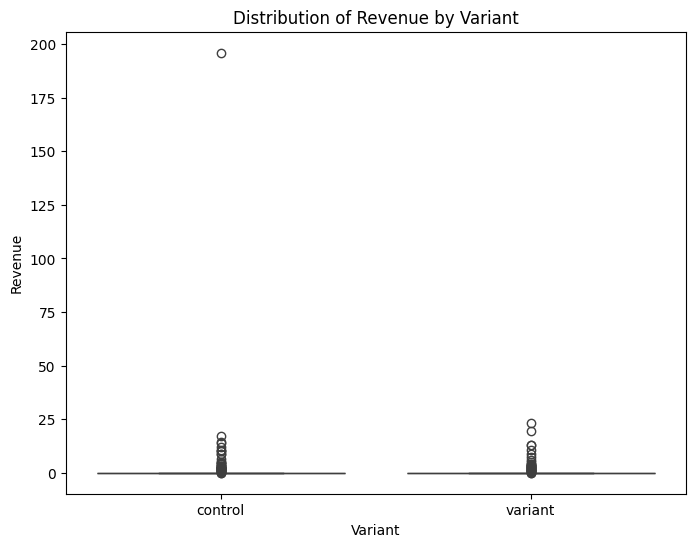

In [77]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=test_group)
plt.title('Distribution of Revenue by Variant')
plt.xlabel('Variant')
plt.ylabel('Revenue')
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [78]:
# TODO : Sort these revenue values in descending order
test_group.sort_values(by='REVENUE', ascending=False, inplace=True)

In [79]:
# TODO : See if user 3342 had other events with a strong outlier
test_group[test_group['USER_ID'] == 3342]


,USER_ID,VARIANT_NAME,REVENUE
1601,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

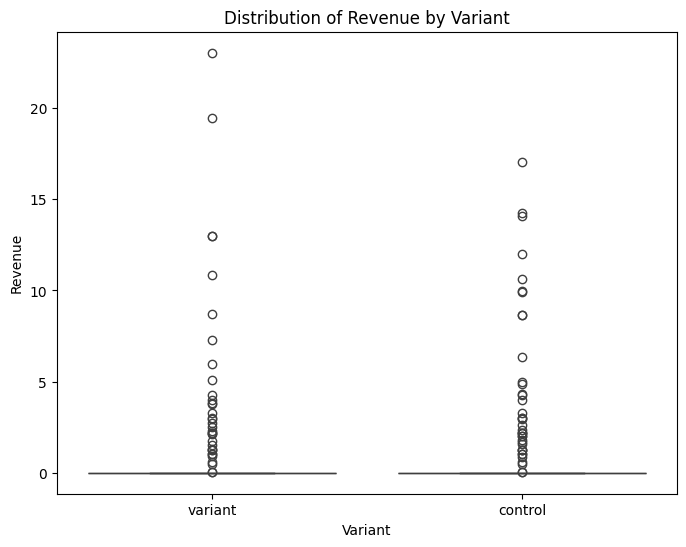

In [80]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
test_group = test_group[test_group['USER_ID'] != 3342]
plt.figure(figsize=(8, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=test_group)
plt.title('Distribution of Revenue by Variant')
plt.xlabel('Variant')
plt.ylabel('Revenue')
plt.show()


What can you say about the users and their purchases ?

In [81]:
# TODO : Check if there are users who have records with zero and positive revenue
revenue_group = test_group.groupby('USER_ID')['REVENUE'].apply(lambda x: (x == 0).any() and (x > 0).any())
revenue_group.value_counts()


,count
REVENUE,
False,4782


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [82]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
test_group = test_group.groupby('USER_ID', as_index=False).agg({
    'REVENUE': 'sum'
})
print(test_group)

      USER_ID  REVENUE
0           2      0.0
1           4      0.0
2           5      0.0
3           6      0.0
4           9      0.0
...       ...      ...
4777     9990      0.0
4778     9992      0.0
4779     9993      0.0
4780     9995      0.0
4781     9998      0.0

[4782 rows x 2 columns]


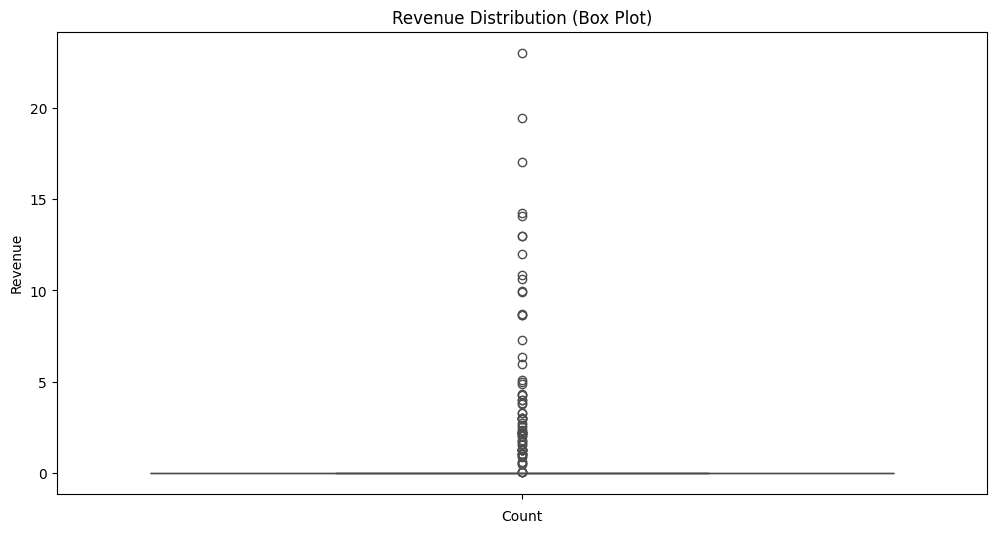

In [88]:
# TODO : Visualize the resulting distribution of the data again.
plt.figure(figsize=(12, 6))

sns.boxplot(y=test_group['REVENUE'], color='orange')
plt.title('Revenue Distribution (Box Plot)')
plt.ylabel('Revenue')
plt.xlabel('Count')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [96]:
# TODO : get metrics by groups
grouped_data = df.groupby('VARIANT_NAME').agg({
    'REVENUE': ['sum', 'mean', 'count', 'std', 'min', 'max']
}).reset_index()
print(grouped_data)

# TODO : create two additional metrics to see relative changes
revenue_control = grouped_data[grouped_data['VARIANT_NAME'] == 'control']['REVENUE']['sum'].values[0]
revenue_variant = grouped_data[grouped_data['VARIANT_NAME'] == 'variant']['REVENUE']['sum'].values[0]
percentage_diff = ((revenue_control - revenue_variant) / revenue_variant) * 100
revenue_ratio = revenue_control / revenue_variant
print(f"Percentage Difference in Revenue: {percentage_diff:.2f}%")
print(f"Revenue Ratio (Variant / Control): {revenue_ratio:.2f}")

# TODO : add them to the rest of the metrics in a separate group
grouped_data['Percentage Difference'] = percentage_diff
grouped_data['Revenue Ratio'] = revenue_ratio

  VARIANT_NAME REVENUE                                       
                   sum      mean count       std  min     max
0      control  643.00  0.129013  4984  3.007524  0.0  196.01
1      variant  351.47  0.070070  5016  1.314802  0.0   58.63
Percentage Difference in Revenue: 82.95%
Revenue Ratio (Variant / Control): 1.83


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

Let's look at the distributions of all and only paying users

<ipython-input-100-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-100-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'

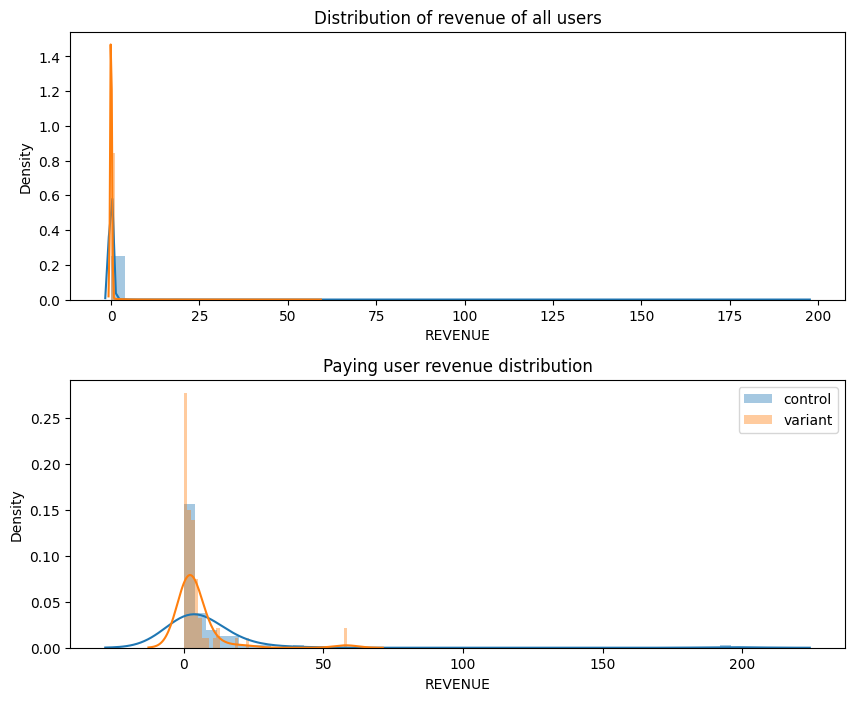

In [100]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [102]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
from scipy import stats
revenue_variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
revenue_control = df[df['VARIANT_NAME'] == 'control']['REVENUE']
stat_variant, p_value_variant = stats.shapiro(revenue_variant)
stat_control, p_value_control = stats.shapiro(revenue_control)
alpha = 0.05
print(f"Variant Group: {p_value_variant}")
print(f"Control Group: {p_value_control}")

if p_value_variant < alpha:
    print("The data for the variant is not normally distributed.")
else:
    print("The data for the variant is normally distributed.")

if p_value_control < alpha:
    print("The data for the control is not normally distributed.")
else:
    print("The data for the control is normally distributed.")

Variant Group: 2.7310104028899288e-95
Control Group: 2.4983285100057203e-95
The data for the variant is not normally distributed.
The data for the control is not normally distributed.


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [103]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,9848
False,152


In [104]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
stat, p_value = stats.mannwhitneyu(revenue_variant, revenue_control)
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the variant and control groups.")
else:
    print("There is no significant difference between the variant and control groups.")

Mann-Whitney U Test Statistic: 12478180.0
P-value: 0.47825247965294926
There is no significant difference between the variant and control groups.


In [106]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
df_paid = df[df['REVENUE'] > 0]
revenue_variant_paid = df_paid[df_paid['VARIANT_NAME'] == 'variant']['REVENUE']
revenue_control_paid = df_paid[df_paid['VARIANT_NAME'] == 'control']['REVENUE']

stat, p_value = stats.mannwhitneyu(revenue_variant_paid, revenue_control_paid)

print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-value: {p_value}")
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the variant and control groups (for users who paid).")
else:
    print("There is no significant difference between the variant and control groups (for users who paid).")

Mann-Whitney U Test Statistic: 2404.0
P-value: 0.07924299810603061
There is no significant difference between the variant and control groups (for users who paid).


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [107]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [108]:
# TODO : Generate samples for all users

In [109]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

NameError: name 'control' is not defined

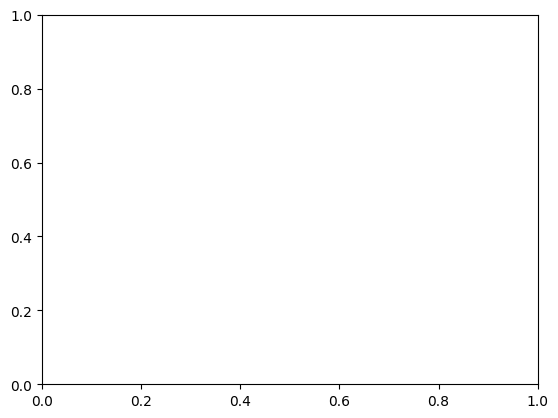

In [63]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
